# Cleaning anomalies in time series per region slug



## Load  libraries

In [2]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

#### Run single

In [5]:
from src.runners.clean import _run_single 

2021-04-16 14:32:50.056 | INFO     | src.runners.clean:_run_single:689 - ... here we go brasilia...

2021-04-16 14:32:50.057 | DEBUG    | src.runners.clean:_reading_data:601 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('brasilia')
        
2021-04-16 14:32:54.035 | DEBUG    | src.runners.clean:_c_param:271 - c_param: 0.3137690911215374
2021-04-16 14:32:54.039 | DEBUG    | src.runners.clean:_run_step:629 - ... step start ...
2021-04-16 14:32:54.039 | INFO     | src.runners.clean:_run_step:630 - Target variable: observed 

2021-04-16 14:32:54.040 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-16 14:32:54.041 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value i

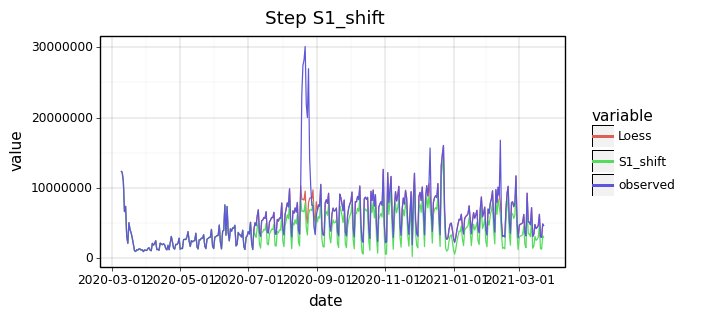

2021-04-16 14:32:55.456 | DEBUG    | src.runners.clean:_run_step:675 - ... step done ...
2021-04-16 14:32:55.474 | DEBUG    | src.runners.clean:_run_step:629 - ... step start ...
2021-04-16 14:32:55.475 | INFO     | src.runners.clean:_run_step:630 - Target variable: S1_shift 

2021-04-16 14:32:55.476 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-16 14:32:55.476 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

<ggplot: (8745673442061)>


2021-04-16 14:32:56.246 | DEBUG    | src.runners.clean:_run_shift_grid:339 - Total combinations: 25
2021-04-16 14:32:56.479 | DEBUG    | src.runners.clean:_initial_shift_date:416 - Shift found at 2020-08-11 00:00:00
2021-04-16 14:32:56.484 | DEBUG    | src.runners.clean:_shift_ts:439 - 

2021-04-16 14:32:56.485 | DEBUG    | src.runners.clean:_shift_ts:440 - Center point: -174410.0
../src/runners/clean.py:444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


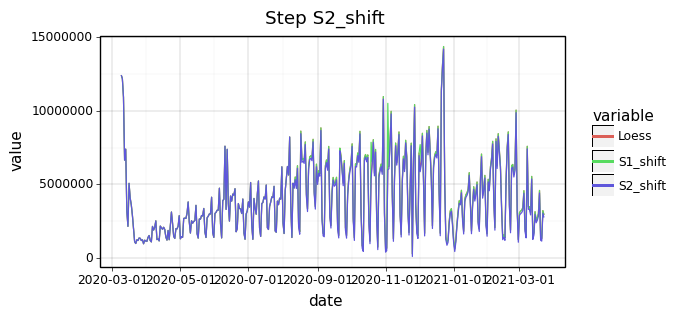

2021-04-16 14:32:56.867 | DEBUG    | src.runners.clean:_run_step:675 - ... step done ...


<ggplot: (8745672467437)>


2021-04-16 14:32:57.223 | DEBUG    | src.runners.clean:_write_missing:608 - ... writing anomalies file ...


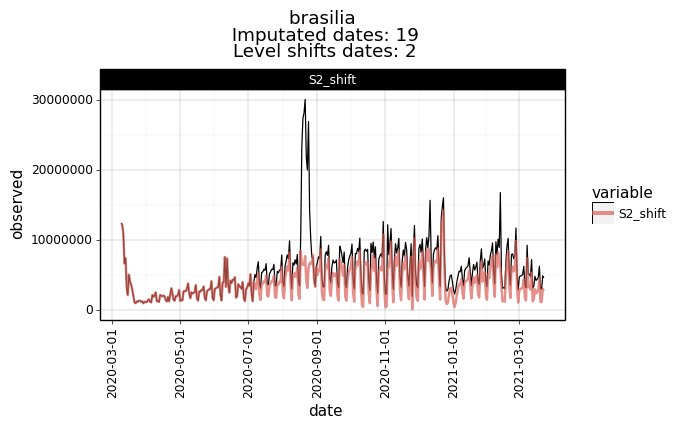

<ggplot: (8745672419649)>


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_brasilia.pdf
2021-04-16 14:32:59.157 | INFO     | src.runners.clean:_run_single:762 - ... brasilia done ...



In [6]:
daily, weekly = _run_single(region_slug='brasilia', 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            print_report = False, 
                            print_plot = True)

In [11]:
import plotnine as p9
p9.theme_set(p9.theme_linedraw()) # default theme

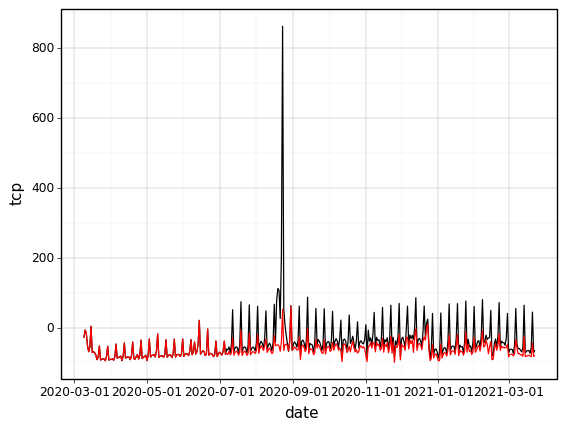

<ggplot: (8745672451097)>

In [12]:
daily.head(3)
(p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))

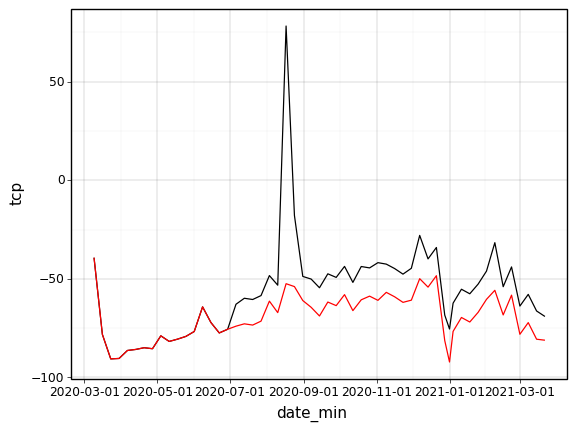

<ggplot: (8745672327693)>

In [13]:
weekly.head(3)
(p9.ggplot(weekly, p9.aes(x = 'date_min', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))

#### Run by batch

In [14]:
from src.runners.clean import _run_batch 

In [ ]:
_run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona")

2021-04-16 14:33:50.137 | INFO     | src.runners.clean:_run_batch:775 - Total regions process108
2021-04-16 14:33:50.137 | INFO     | src.runners.clean:_run_single:689 - ... here we go aguascalientes...

2021-04-16 14:33:50.140 | DEBUG    | src.runners.clean:_reading_data:601 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('aguascalientes')
        


aguascalientes


2021-04-16 14:33:51.624 | DEBUG    | src.runners.clean:_c_param:271 - c_param: 0.6731352363084672
2021-04-16 14:33:51.627 | DEBUG    | src.runners.clean:_run_step:629 - ... step start ...
2021-04-16 14:33:51.628 | INFO     | src.runners.clean:_run_step:630 - Target variable: observed 

2021-04-16 14:33:51.628 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-16 14:33:51.630 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

arequipa


2021-04-16 14:33:57.335 | DEBUG    | src.runners.clean:_c_param:271 - c_param: 0.6206486994942879
2021-04-16 14:33:57.339 | DEBUG    | src.runners.clean:_run_step:629 - ... step start ...
2021-04-16 14:33:57.340 | INFO     | src.runners.clean:_run_step:630 - Target variable: observed 

2021-04-16 14:33:57.341 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-16 14:33:57.344 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

barranquilla


2021-04-16 14:34:03.879 | DEBUG    | src.runners.clean:_c_param:271 - c_param: 0.7170434295252509
2021-04-16 14:34:03.883 | DEBUG    | src.runners.clean:_run_step:629 - ... step start ...
2021-04-16 14:34:03.884 | INFO     | src.runners.clean:_run_step:630 - Target variable: observed 

2021-04-16 14:34:03.884 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-16 14:34:03.885 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

belem


2021-04-16 14:34:10.506 | DEBUG    | src.runners.clean:_c_param:271 - c_param: 0.36855976261480944
2021-04-16 14:34:10.509 | DEBUG    | src.runners.clean:_run_step:629 - ... step start ...
2021-04-16 14:34:10.510 | INFO     | src.runners.clean:_run_step:630 - Target variable: observed 

2021-04-16 14:34:10.511 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-16 14:34:10.511 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

belohorizonte


In [ ]:
df = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index.csv")
head(df)

In [ ]:
#plt.scatter(df.tcp, df.tcp_clean)
#df[['date', 'region_slug', 'tcp_clean']] 

In [ ]:
df.head()
df.describe()

In [ ]:
df.region_slug.unique()

In [ ]:
(df
 >> group_by('region_slug')
 >> summarize(min_tcp = _.tcp_clean.abs().min(),
              max_tcp = _.tcp_clean.abs().max(), 
              min_baseline = _.expected_2020.abs().min()/1e6,
              max_baseline = _.expected_2020.abs().max()/1e6,
              min_observed = _.observed.abs().min()/1e6,
              max_observed = _.observed.abs().max()/1e6,
              min_cleaned = _.S2_shift.abs().min()/1e6,
              max_cleaned = _.S2_shift.abs().max()/1e6
              )
 >> arrange(_.max_tcp)
).tail(15)

#### Step run

In [ ]:
df_cty = _load_data()

In [ ]:
df_run_1 = _run_step(df_run = df_cty[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
df_run_1.head()

In [ ]:
df_run_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
qry = """
select 
    *
from spd_sdv_waze_corona.prod_daily_weekly_index
limit 10
"""
df = pd.read_sql_query(qry, conn)

In [ ]:
df.columns #sort_values('week_number')

In [17]:
import pandas as pd
metadata = pd.read_csv("http://tiny.cc/idb-traffic-metadata")

In [23]:
print(len(metadata.region_slug))
print(metadata.region_slug.unique())

metadata.head()

139
['country_guatemala' 'barranquilla' 'buenosaires' 'caracas'
 'br_states_maranhao' 'maracay' 'country_dominican_republic' 'saopaulo'
 'manaus' 'br_states_minas_gerais' 'montevideo' 'merida' 'ciudad_guayana'
 'br_states_amazonas' 'lapaz' 'country_peru' 'sanpedrosula'
 'country_argentina' 'br_states_rio_de_janeiro' 'cordoba'
 'country_el_salvador' 'bucaramanga' 'tijuana' 'medellin'
 'br_states_mato_grosso' 'maceio' 'br_states_pernambuco' 'guayaquil'
 'br_states_paraiba' 'country_nicaragua' 'santodomingo' 'panamacity'
 'sanfernado' 'arequipa' 'country_uruguay' 'guatemala' 'natal'
 'sanluispotosi' 'georgetown' 'br_states_santa_catarina' 'santamarta'
 'sansalvador' 'juarez' 'br_states_para' 'salvador' 'br_states_alagoas'
 'br_states_espirito_santo' 'tegucigalpa' 'country_costa_rica'
 'br_states_bahia' 'bridgetown' 'riodejaneiro' 'cucuta' 'br_states_amapa'
 'toluca' 'bogota' 'managua' 'country_honduras' 'queretaro'
 'br_states_piaui' 'leon' 'country_paraguay' 'country_guyana'
 'country_ja

,country_name,country_iso,region_slug,region_name,region_type,population,timezone,region_shapefile_wkt,osm_length,daily_coef_var,...,daily_coef_var_weekday,weekend_osm_ratio,weekday_osm_ratio,daily_approved,weekly_approved,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,Guatemala,GT,country_guatemala,Guatemala,country,17915567.0,America/Guatemala,MULTIPOLYGON (((-92.2393264773401 14.541251788...,5.664239e+07,0.257001,...,0.253105,0.958859,1.153470,True,True,NaN,NaN,NaN,NaN,NaN
1,Colombia,CO,barranquilla,Barranquilla,city,1931750.0,America/Bogota,POLYGON ((-74.83374991971161 11.04958488300598...,2.609151e+06,0.316392,...,0.346008,3.327034,4.944916,True,True,NaN,NaN,NaN,NaN,NaN
2,Argentina,AR,buenosaires,Buenos Aires,city,14338718.0,America/Argentina/Buenos_Aires,POLYGON ((-58.75041764050466 -34.3670848864218...,3.033681e+07,0.326066,...,0.423715,1.914411,2.969939,True,True,NaN,NaN,NaN,NaN,NaN
3,Venezuela,VE,caracas,Caracas,city,2408266.0,America/Caracas,POLYGON ((-67.00833333335606 10.39999999997973...,3.187649e+06,0.758516,...,1.737158,0.571506,1.639975,False,False,NaN,NaN,NaN,NaN,NaN
4,Brasil,BR,br_states_maranhao,Maranhao,state,NaN,NaN,POLYGON ((-45.84073319904228 -1.04548473090940...,7.803499e+07,0.355675,...,0.421830,0.376916,0.475001,True,True,NaN,NaN,NaN,NaN,NaN


In [31]:
metadata[metadata.region_slug == 'mexicocity'].region_shapefile_wkt.to_list()

['POLYGON ((-99.22541498771096 19.79958548078565, -99.19208165656235 19.79958548078565, -99.17541499098803 19.77458547907771, -99.15041499262657 19.77458547907771, -99.15041499262657 19.73291880956447, -99.12541499426511 19.73291880956447, -99.10041499590365 19.70791880785653, -99.06708166475504 19.71625214175918, -99.06708166475504 19.69125214005124, -98.99208166967065 19.70791880785653, -98.96708167130919 19.74125214346712, -98.92541500737342 19.69958547395388, -98.95041500573488 19.69125214005124, -98.95874833852204 19.65791880444065, -98.97541500409635 19.65791880444065, -98.96708167130919 19.63291880273271, -98.94208167294772 19.63291880273271, -98.91708167458627 19.65791880444065, -98.8754150106505 19.649585470538, -98.88374834343765 19.63291880273271, -98.90874834179911 19.63291880273271, -98.88374834343765 19.61625213492741, -98.89208167622481 19.59125213321947, -98.85041501228903 19.54125212980358, -98.85041501228903 19.49958546029035, -98.8754150106505 19.47458545858241, -98.